<a href="https://colab.research.google.com/github/stephen-osullivan/pytorch/blob/main/torch_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q torch torchvision

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using:', device)

Using: cuda


In [ ]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

--2023-10-04 10:15:19--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.239.225.75, 18.239.225.61, 18.239.225.55, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.239.225.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   137MB/s    in 0.3s    

2023-10-04 10:15:20 (137 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [ ]:
!unzip hymenoptera_data.zip

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera_data/train/ants/147318

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_dir = 'hymenoptera_data'
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'val']}
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=4,shuffle=True, num_workers=4)
    for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


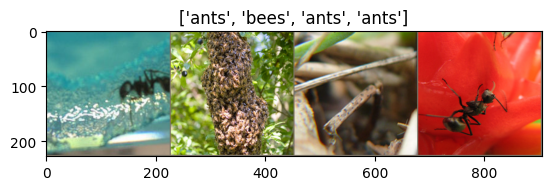

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
os.makedirs('temp', exist_ok=True)
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, device = 'cpu'):
    model = model.to(device)
    since = time.time()
    best_model_params_path = os.path.join('temp', 'best_model_params.pt')
    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)

        print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [ ]:
model_ft = models.resnet18()#(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
t0 = time.time()
model_conv = train_model(model_ft, criterion, optimizer_ft,
                         exp_lr_scheduler, num_epochs=10, device = device)

Epoch 0/9
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.7610 Acc: 0.5082
val Loss: 0.7108 Acc: 0.5752

Training complete in 0m 5s
Best val Acc: 0.575163
Epoch 1/9
----------
train Loss: 0.8407 Acc: 0.5123
val Loss: 0.6672 Acc: 0.6144

Training complete in 0m 10s
Best val Acc: 0.614379
Epoch 2/9
----------
train Loss: 0.7688 Acc: 0.5000
val Loss: 1.0064 Acc: 0.5425

Training complete in 0m 16s
Best val Acc: 0.614379
Epoch 3/9
----------
train Loss: 0.7408 Acc: 0.5533
val Loss: 0.6087 Acc: 0.6797

Training complete in 0m 20s
Best val Acc: 0.679739
Epoch 4/9
----------
train Loss: 0.6890 Acc: 0.6189
val Loss: 0.6831 Acc: 0.6928

Training complete in 0m 23s
Best val Acc: 0.692810
Epoch 5/9
----------
train Loss: 0.7837 Acc: 0.6025
val Loss: 0.8750 Acc: 0.6013

Training complete in 0m 29s
Best val Acc: 0.692810
Epoch 6/9
----------
train Loss: 0.8143 Acc: 0.5328
val Loss: 0.6643 Acc: 0.6667

Training complete in 0m 32s
Best val Acc: 0.692810
Epoch 7/9
----------
train Loss: 0.6254 Acc: 0.6434
val Loss: 0.6480 Acc: 0.7059

Training 